In [152]:
import pandas as pd
from pathlib import Path  
import sys
import sqlite3

CUT_OF_UNIQUE_VALUES=40

In [153]:
data_filtered_cedd=pd.read_csv("cleaned_data_with_binary_dead.csv")
df_counts  = pd.DataFrame(columns = ['col', 'count'])
for col in data_filtered_cedd:
    no_of_unique_values=data_filtered_cedd[col].nunique()
    df_counts.loc[len(df_counts)]=[col,no_of_unique_values]
#     if( not col.startswith( 'Unnamed' ) && no_of_unique_values<20):
#         print("%s--->%s"%(col,))
df_counts = df_counts.sort_values(by=['count'], ascending=False)
display(df_counts.head(30))

count=0

for col in data_filtered_cedd:
    no_of_unique_values=data_filtered_cedd[col].nunique()
    if( not col.startswith( 'Unnamed' ) and no_of_unique_values<40):
        count =count+1
        #data_filtered_cedd[col].fillna("imputed",inplace=True)
        data_filtered_cedd[col]=pd.Categorical(data_filtered_cedd[col])
                
data_filtered_cedd.dtypes.value_counts()



count


    



C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (75,83,88,136) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,col,count
0,Unnamed: 0,28122
2,Unnamed: 0.1.1,28122
1,Unnamed: 0.1,28122
29,ceo_id,15744
28,epi_id,7432
4,pa_id,5930
13,epi_SocDate,1056
22,icd_code,967
23,icd_code_description,965
14,epi_StartOfEpisode,833


133

### New Binary Column for label and drop alive patients with less than 365 days of history

In [154]:
from datetime import timedelta
import numpy as np

##### adding our binary column to denote if patient is dead
df = data_filtered_cedd
df['patient_deceased'] = np.where((df['DaysToDeath'] <= 365) | (df['dcc_desc'] == 'PATIENT EXPIRED'), 1, 0)

In [155]:
##### defining our year threshold, and converting neccesary col's to datetimes

threesixtyfive = timedelta(days = 365)

df['epi_SocDate'] = pd.to_datetime(df['epi_SocDate'])
df['epi_EndOfEpisode'] = pd.to_datetime(df['epi_EndOfEpisode'])

In [156]:
##### dropping all 'alive' patients with LESS than a year of history

for index, row in df.iterrows():
    if row['patient_deceased'] == 0 and row['epi_EndOfEpisode'] - row['epi_SocDate'] < threesixtyfive:
        df.drop(index, axis = 0, inplace = True)

In [157]:
##### dropping all 'dead' patients with MORE than a year of history

for index, row in df.iterrows():
    if row['patient_deceased'] == 1 and row['epi_EndOfEpisode'] - row['epi_SocDate'] > threesixtyfive:
        row['patient_deceased'] == 0

In [158]:
df["M1056_PVX_RSN_NOT_RCVD_AGNCY"].cat.categories
df.groupby(['M1056_PVX_RSN_NOT_RCVD_AGNCY']).size()

df["M1200_VISION"].cat.categories
df.groupby(['M1200_VISION']).size()

M1200_VISION
0 - NORMAL VISION: SEES ADEQUATELY IN MOST SITUATIONS; CAN SEE MEDICATION LABELS, NEWSPRINT                                                                        5242
1 - PARTIALLY IMPAIRED: CANNOT SEE MEDICATION LABELS OR NEWSPRINT, BUT CAN SEE OBSTACLES IN PATH, AND THE SURROUNDING LAYOUT; CAN COUNT FINGERS AT ARM'S LENGTH    1847
2 - SEVERELY IMPAIRED: CANNOT LOCATE OBJECTS WITHOUT HEARING OR TOUCHING THEM OR PATIENT NONRESPONSIVE                                                               95
dtype: int64

### Drop columns with no meaning

In [159]:
df = df.drop(columns=['CreatedDate', 'CreatedBy', 'UpdateDate', 'UpdateBy', 'ActiveFlag'])

In [160]:
df['DaysToDeath']

40       194.0
41       194.0
42       194.0
43       194.0
76        12.0
         ...  
28117      2.0
28118      2.0
28119      2.0
28120      2.0
28121      2.0
Name: DaysToDeath, Length: 12981, dtype: float64

### Find columns with name ID

In [161]:
[col for col in df.columns if 'id' in col]

['pa_id', 'epi_dcrid', 'epi_id', 'ceo_id']

In [162]:
[col for col in df.columns if 'Id' in col]

['DispositionId']

### Drop ID columns... this could give model too much hint

In [163]:
df = df.drop(columns=['DispositionId', 'pa_id', 'epi_dcrid', 'epi_id', 'ceo_id'])

### Drop records with DaysToDeath = 0

In [164]:
df.dropna(subset=['DaysToDeath'])

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,year_born,pa_race,pa_gender,pa_maritalstatus,epi_AdmitType,dcc_desc,dcr_desc,...,M2310_ECR_UNKNOWN,M2401_INTRVTN_SMRY_DBTS_FT,M2401_INTRVTN_SMRY_DPRSN,M2401_INTRVTN_SMRY_FALL_PRVNT,M2401_INTRVTN_SMRY_PAIN_MNTR,M2401_INTRVTN_SMRY_PRSULC_PRVN,M2401_INTRVTN_SMRY_PRSULC_WET,M2410_INPAT_FACILITY,M2420_DSCHRG_DISP,patient_deceased
40,40,40,40,1930,NaN,MALE,NaN,RECERTIFICATION,PATIENT EXPIRED,PATIENT EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
41,41,41,41,1930,NaN,MALE,NaN,RECERTIFICATION,PATIENT EXPIRED,PATIENT EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
42,42,42,42,1930,NaN,MALE,NaN,RECERTIFICATION,PATIENT EXPIRED,PATIENT EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
43,43,43,43,1930,NaN,MALE,NaN,RECERTIFICATION,PATIENT EXPIRED,PATIENT EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
76,76,76,76,1966,NaN,FEMALE,NaN,NEW ADMISSION,PATIENT EXPIRED,PATIENT EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28117,28117,28117,28117,1940,NaN,FEMALE,NaN,NEW ADMISSION,PATIENT EXPIRED,PATIENT EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
28118,28118,28118,28118,1940,NaN,FEMALE,NaN,NEW ADMISSION,PATIENT EXPIRED,PATIENT EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
28119,28119,28119,28119,1940,NaN,FEMALE,NaN,NEW ADMISSION,PATIENT EXPIRED,PATIENT EXPIRED,...,NO,NA - PATIENT IS NOT DIABETIC OR IS MISSING LOW...,NA - (C2) PATIENT HAS NO DIAGNOSIS OF DEPRESSI...,1 - YES,1 - YES,1 - YES,NA - PATIENT HAS NO PRESSURE ULCERS OR HAS NO ...,1 - HOSPITAL,NaN,1
28120,28120,28120,28120,1940,NaN,FEMALE,NaN,NEW ADMISSION,PATIENT EXPIRED,PATIENT EXPIRED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [165]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df.select_dtypes(include=numerics)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,year_born,epi_height,epi_weight,DaysToDeath,RoughAge,patient_deceased
40,40,40,40,1930,NaN,NaN,194.0,NaN,1
41,41,41,41,1930,NaN,NaN,194.0,NaN,1
42,42,42,42,1930,NaN,NaN,194.0,NaN,1
43,43,43,43,1930,NaN,NaN,194.0,NaN,1
76,76,76,76,1966,NaN,NaN,12.0,NaN,1
...,...,...,...,...,...,...,...,...,...
28117,28117,28117,28117,1940,NaN,NaN,2.0,82.0,1
28118,28118,28118,28118,1940,NaN,NaN,2.0,82.0,1
28119,28119,28119,28119,1940,NaN,NaN,2.0,82.0,1
28120,28120,28120,28120,1940,NaN,NaN,2.0,82.0,1


### Drop columns that are giving hints as response variables (like cedd_dateofdeath).

In [166]:
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'])

In [167]:
### Also drop dcc_desc and dcr_desc

In [168]:
df.drop(['M2200_THER_NEED_NBR', 'M1322_NBR_PRSULC_STG1', 'M0090_INFO_COMPLETED_DT', 
         'ceo_OASIScorrectionnum', 'DaysToDeath', 'cedd_dateofdeath', 'ceas_ascode', 
         'epi_DischargeDate', 'epi_EndOfEpisode', 'epi_StartOfEpisode', 'epi_SocDate', 
         'dcr_desc', 'dcc_desc', 'icd_code_description'], inplace = True, axis = 1)

In [169]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import numpy as np

imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='imputed')
idf = pd.DataFrame(imputer.fit_transform(df))
idf.columns=df.columns
# idf.index=df.index

#
df = idf
for col in df:
    no_of_unique_values=df[col].nunique()
    if( not col.startswith( 'Unnamed' ) and no_of_unique_values<40):        
        df[col]=pd.Categorical(df[col])

In [170]:
df.dtypes

year_born                           object
pa_race                           category
pa_gender                         category
pa_maritalstatus                  category
epi_AdmitType                     category
                                    ...   
M2401_INTRVTN_SMRY_PRSULC_PRVN    category
M2401_INTRVTN_SMRY_PRSULC_WET     category
M2410_INPAT_FACILITY              category
M2420_DSCHRG_DISP                 category
patient_deceased                  category
Length: 129, dtype: object

#### detect columns that contain numeric value when it shouldn't be. (This runs quite a long time)

In [171]:
for column_name in df.columns:
    if column_name != 'year_born':
        for index, row in df.iterrows():
            if isinstance(row[column_name], (int, float)):
                print(column_name)
                df[column_name] = df[column_name].astype(str)
                break

pa_race
pa_maritalstatus
epi_height
epi_weight
RoughAge
M1311_NBR_ULC_SOCROC_STG2_A2
M1311_NBR_ULC_SOCROC_STG3_B2
M1311_NBR_ULC_SOCROC_STG4_C2
M1311_NSTG_CVRG_SOCROC_E2
M1311_NSTG_DEEP_TSUE_SOCROC_F2
M1311_NSTG_DRSG_SOCROC_D2
patient_deceased


In [172]:
# Use Ordinal Encoder for all numeric type category

from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
enc.fit(df)
enc.categories_

[array([1909, 1914, 1915, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924,
        1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935,
        1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946,
        1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957,
        1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
        1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
        1980, 1981, 1982, 1983, 1984, 1985, 1988, 1989, 1990, 1993, 1996,
        1999, 2011], dtype=object),
 array(['1.0', '2.0', '3.0', '5.0', '6.0', 'imputed'], dtype=object),
 array(['FEMALE', 'MALE  '], dtype=object),
 array(['1.0', '2.0', '25000.0', '3.0', '4.0', '5.0', '6.0', '8.0',
        'imputed'], dtype=object),
 array(['NEW ADMISSION', 'READMISSION', 'RECERTIFICATION'], dtype=object),
 array(['5.0', '5.3', '5.6', '55.0', '56.25', '57.0', '59.0', '59.8',
        '60.0', '60.5', '60.98', '61.0', '61.2', '61.96', '61.97', '62.0',
        '

In [173]:
xdf = enc.transform(df) # transform using encoder

In [174]:
df2 = pd.DataFrame(xdf, columns=df.columns) # numpy to dataframe

In [175]:
X = df2.iloc[:,:-1]

In [176]:
y = df2.iloc[:,-1:]

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=42)

### Quick Evaluation using RFE Feature Selection: LogisticRegression

In [178]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [179]:
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=10, verbose=1)

rfe.fit(X_train, y_train)

print(dict(zip(X.columns, rfe.ranking_)))

Fitting estimator with 128 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

Fitting estimator with 127 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 126 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 125 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 124 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 123 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 122 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 121 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 120 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 119 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 118 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 117 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 116 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 115 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 114 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 113 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 112 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 111 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 110 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 109 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 108 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 107 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 106 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 105 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 104 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 103 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 102 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 101 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 100 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 99 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 98 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 97 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 96 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 95 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 94 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 93 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 92 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 91 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 90 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 89 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 88 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 87 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 86 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 85 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 84 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 83 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 82 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 81 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 80 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 79 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 78 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 77 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 76 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 75 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 74 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 73 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 72 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 71 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 70 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 69 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 68 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 67 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 66 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 65 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

Fitting estimator with 64 features.
Fitting estimator with 63 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

Fitting estimator with 62 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 61 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 60 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 59 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 58 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 57 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 56 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 55 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 54 features.
Fitting estimator with 53 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

Fitting estimator with 52 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 51 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 50 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 49 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

Fitting estimator with 48 features.
Fitting estimator with 47 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

Fitting estimator with 46 features.
Fitting estimator with 45 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 44 features.
Fitting estimator with 43 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

Fitting estimator with 42 features.
Fitting estimator with 41 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

Fitting estimator with 40 features.
Fitting estimator with 39 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

Fitting estimator with 38 features.
Fitting estimator with 37 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

Fitting estimator with 36 features.
Fitting estimator with 35 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

Fitting estimator with 34 features.
Fitting estimator with 33 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

Fitting estimator with 32 features.
Fitting estimator with 31 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

Fitting estimator with 30 features.
Fitting estimator with 29 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

Fitting estimator with 28 features.
Fitting estimator with 27 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

Fitting estimator with 26 features.
Fitting estimator with 25 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

Fitting estimator with 24 features.
Fitting estimator with 23 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

Fitting estimator with 22 features.
Fitting estimator with 21 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

Fitting estimator with 20 features.
Fitting estimator with 19 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

Fitting estimator with 18 features.
Fitting estimator with 17 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

Fitting estimator with 16 features.
Fitting estimator with 15 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

Fitting estimator with 14 features.
Fitting estimator with 13 features.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

Fitting estimator with 12 features.
Fitting estimator with 11 features.
{'year_born': 86, 'pa_race': 35, 'pa_gender': 85, 'pa_maritalstatus': 52, 'epi_AdmitType': 1, 'epi_height': 93, 'epi_weight': 109, 'ceo_HIPPS': 89, 'ceo_HHRG': 77, 'icd_code': 119, 'DiagnosisCategory': 47, 'RoughAge': 8, 'M0100_ASSMT_REASON': 97, 'M0110_EPISODE_TIMING': 98, 'M0140_ETHNIC_AI_AN': 12, 'M0140_ETHNIC_ASIAN': 19, 'M0140_ETHNIC_BLACK': 61, 'M0140_ETHNIC_HISP': 43, 'M0140_ETHNIC_NH_PI': 28, 'M0140_ETHNIC_WHITE': 113, 'M0906_DC_TRAN_DTH_DT': 106, 'M1000_DC_IPPS_14_DA': 65, 'M1000_DC_IRF_14_DA': 1, 'M1000_DC_LTC_14_DA': 15, 'M1000_DC_LTCH_14_DA': 10, 'M1000_DC_NONE_14_DA': 76, 'M1000_DC_OTH_14_DA': 20, 'M1000_DC_PSYCH_14_DA': 25, 'M1000_DC_SNF_14_DA': 71, 'M1028_ACTV_DIAG_DM': 112, 'M1028_ACTV_DIAG_NOA': 107, 'M1028_ACTV_DIAG_PVD_PAD': 108, 'M1030_THH_ENT_NUTRITION': 1, 'M1030_THH_IV_INFUSION': 66, 'M1030_THH_NONE_ABOVE': 1, 'M1030_THH_PAR_NUTRITION': 9, 'M1033_HOSP_RISK_5PLUS_MDCTN': 99, 'M1033_HOSP_RISK_C

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

In [180]:
print(X.columns[rfe.support_])

Index(['epi_AdmitType', 'M1000_DC_IRF_14_DA', 'M1030_THH_ENT_NUTRITION',
       'M1030_THH_NONE_ABOVE', 'M1033_HOSP_RISK_NONE_ABOVE',
       'M1033_HOSP_RISK_WEIGHT_LOSS', 'M1311_NBR_ULC_SOCROC_STG4_C2',
       'M1600_UTI', 'M2401_INTRVTN_SMRY_FALL_PRVNT', 'M2420_DSCHRG_DISP'],
      dtype='object')


In [181]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, rfe.predict(X_test))

In [182]:
print("{0:.1%} accuracy on test set.".format(acc))

96.0% accuracy on test set.


### Quick Evaluation using RFE Feature Selection: RandomForest

In [183]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

# Calculate the accuracy
acc = accuracy_score(y_test, rf.predict(X_test))

# Print the importances per feature
# print(dict(zip(X.columns, rf.feature_importances_.round(2))))

# Print accuracy
print("{0:.1%} accuracy on test set.".format(acc))

C:\Users\sjyhl\AppData\Local\Temp/ipykernel_18456/3044802180.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


99.1% accuracy on test set.


In [184]:
mask = rf.feature_importances_ > 0.03

# Apply the mask to the feature dataset X
reduced_X = X.loc[:, mask]

# Prints out the selected column names
print(reduced_X.columns)

Index(['year_born', 'epi_AdmitType', 'icd_code', 'RoughAge',
       'M0906_DC_TRAN_DTH_DT'],
      dtype='object')


### Check regularizing strength (LASSO)

In [185]:
from sklearn.linear_model import Lasso
alpha_list = [10, 1, 0.5, 0.1, 0.01, 0.001, 0.0001, 0.00001]
max_r = 0
max_alpha = 0
for alpha in alpha_list:
    
    la = Lasso(alpha=alpha, random_state=0)

    
    la.fit(X_train, y_train)
    r_squared = la.score(X_test, y_test)
    n_ignored_features = sum(la.coef_ == 0)

    
    print("The model can predict {0:.1%} of the variance in the test set.".format(r_squared))
    print("{} out of {} features were ignored.".format(n_ignored_features, len(la.coef_)))
    
    if r_squared > 0.98:
        max_r = r_squared
        max_alpha = alpha
        break
print("Max R-squared: {}, alpha: {}".format(max_r, max_alpha))

The model can predict -0.0% of the variance in the test set.
128 out of 128 features were ignored.
The model can predict 1.4% of the variance in the test set.
125 out of 128 features were ignored.
The model can predict 1.8% of the variance in the test set.
125 out of 128 features were ignored.
The model can predict 4.1% of the variance in the test set.
122 out of 128 features were ignored.
The model can predict 16.5% of the variance in the test set.
110 out of 128 features were ignored.
The model can predict 19.0% of the variance in the test set.
86 out of 128 features were ignored.


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.318e+02, tolerance: 3.328e-02
  model = cd_fast.enet_coordinate_descent(


The model can predict 19.6% of the variance in the test set.
22 out of 128 features were ignored.
The model can predict 19.3% of the variance in the test set.
1 out of 128 features were ignored.
Max R-squared: 0, alpha: 0


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.325e+02, tolerance: 3.328e-02
  model = cd_fast.enet_coordinate_descent(


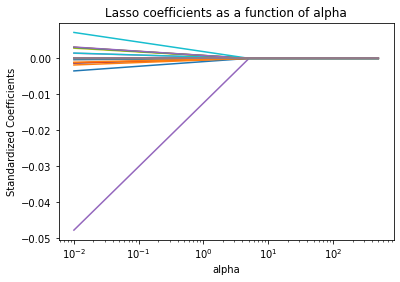

In [186]:
import matplotlib.pyplot as plt

alphas = np.linspace(0.01,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

### LASSO CV - Model w/ best alpha

In [187]:
from sklearn.linear_model import LassoCV

# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=0, max_iter=10000)

# Fit model
model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=0)

model.alpha_

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1572: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.002091838496743041

### Set best alpha and get coefficients

In [188]:
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)
print([coef for coef in list(zip(lasso_best.coef_, X)) if abs(coef[0]) > 0])

[(-0.001418107202889122, 'year_born'), (0.00896525503518365, 'pa_race'), (-0.003995317124543121, 'pa_maritalstatus'), (-0.05620971939455633, 'epi_AdmitType'), (-0.0002915495479309271, 'epi_height'), (0.0001956711095356565, 'epi_weight'), (-0.00047474634581161953, 'ceo_HIPPS'), (0.0031379468498899067, 'ceo_HHRG'), (2.8413661175362136e-06, 'icd_code'), (-0.004479588997414752, 'DiagnosisCategory'), (-0.0020198905459309128, 'RoughAge'), (0.000989999832833109, 'M0100_ASSMT_REASON'), (0.00016049982768864457, 'M0906_DC_TRAN_DTH_DT'), (0.00434384709137388, 'M1046_INFLNZ_RECD_CRNT_SEASON'), (0.0003348252054217374, 'M1056_PVX_RSN_NOT_RCVD_AGNCY'), (0.00020688712130361388, 'M1060_HEIGHT_A'), (4.815944818311894e-05, 'M1060_WEIGHT_B'), (0.0008834105491938272, 'M1200_VISION'), (-0.001483647897077315, 'M1324_STG_PRBLM_ULCER'), (0.0070501574882059275, 'M1330_STAS_ULCR_PRSNT'), (0.012668348588590415, 'M1332_NBR_STAS_ULCR'), (0.0051437521379758475, 'M1340_SRGCL_WND_PRSNT'), (0.004994348614164547, 'M1400

In [189]:
[coef[1] for coef in list(zip(lasso_best.coef_, X)) if abs(coef[0]) > 0]

['year_born',
 'pa_race',
 'pa_maritalstatus',
 'epi_AdmitType',
 'epi_height',
 'epi_weight',
 'ceo_HIPPS',
 'ceo_HHRG',
 'icd_code',
 'DiagnosisCategory',
 'RoughAge',
 'M0100_ASSMT_REASON',
 'M0906_DC_TRAN_DTH_DT',
 'M1046_INFLNZ_RECD_CRNT_SEASON',
 'M1056_PVX_RSN_NOT_RCVD_AGNCY',
 'M1060_HEIGHT_A',
 'M1060_WEIGHT_B',
 'M1200_VISION',
 'M1324_STG_PRBLM_ULCER',
 'M1330_STAS_ULCR_PRSNT',
 'M1332_NBR_STAS_ULCR',
 'M1340_SRGCL_WND_PRSNT',
 'M1400_WHEN_DYSPNEIC',
 'M1600_UTI',
 'M1620_BWL_INCONT',
 'M1810_CRNT_DRESS_UPPER',
 'M1845_CRNT_TOILTG_HYGN',
 'M1850_CRNT_TRNSFRNG',
 'M1870_CRNT_FEEDING',
 'M2030_CRNT_MGMT_INJCTN_MDCTN',
 'M2401_INTRVTN_SMRY_PRSULC_WET',
 'M2410_INPAT_FACILITY']

### Misc Facts about data

#### some columns have '-' as category

In [190]:
df.M1028_ACTV_DIAG_DM.unique() 

['imputed', 'NO', 'YES', '-']
Categories (4, object): ['-', 'NO', 'YES', 'imputed']

In [191]:
df.M1028_ACTV_DIAG_PVD_PAD.unique() 

['imputed', 'NO', 'YES', '-']
Categories (4, object): ['-', 'NO', 'YES', 'imputed']

In [192]:
df.M2003_MDCTN_FLWP.unique() 

['imputed', '0 - NO', '1 - YES', '-']
Categories (4, object): ['-', '0 - NO', '1 - YES', 'imputed']

In [193]:
# fix above. make '-' into 'imputed'
df.loc[df["M1028_ACTV_DIAG_DM"] == "-", "M1028_ACTV_DIAG_DM"] = 'imputed'
df.loc[df["M1028_ACTV_DIAG_PVD_PAD"] == "-", "M1028_ACTV_DIAG_PVD_PAD"] ='imputed'
df.loc[df["M2003_MDCTN_FLWP"] == "-", "M2003_MDCTN_FLWP"] = 'imputed'

#### some columns represent single variable type, some are over multiple columns

In [194]:
list(df.M1400_WHEN_DYSPNEIC.unique())

['2 - WITH MODERATE EXERTION (FOR EXAMPLE, WHILE DRESSING, USING COMMODE OR BEDPAN, WALKING DISTANCES LESS THAN 20 FEET)',
 'imputed',
 '3 - WITH MINIMAL EXERTION (FOR EXAMPLE, WHILE EATING, TALKING, OR PERFORMING OTHER ADLS) OR WITH AGITATION',
 '4 - AT REST (DURING DAY OR NIGHT)',
 '0 - PATIENT IS NOT SHORT OF BREATH ',
 '1 - WHEN WALKING MORE THAN 20 FEET, CLIMBING STAIRS ']

In [195]:
list(df.M1033_HOSP_RISK_MLTPL_HOSPZTN.unique())

['imputed', 'YES', 'NO']

### Feature Evaluation using Regression

In [196]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

names=pd.DataFrame(X_train.columns)

lin_reg = LogisticRegression()

rfe_mod = RFE(lin_reg, n_features_to_select=5, step=1)

fit_model = rfe_mod.fit(X_train, y_train)
fit_model.support_
fit_model.ranking_

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

array([ 91,  40,  90,  57,   1,  98, 114,  94,  82, 124,  52,  13, 102,
       103,  17,  24,  66,  48,  33, 118, 111,  70,   3,  20,  15,  81,
        25,  30,  76, 117, 112, 113,   1,  71,   2,  14, 104,  93,  95,
       109,  84,  77,  35,   1, 121,   1,  89,  34,  87, 107,  75,  45,
        80,  38,  55,   7,  27, 122, 119,  32,   8,   6, 123,  12,  56,
        10,  26,   9, 120,  29,  28,  42,  61,  68,  58,   5,  64, 116,
        83, 105,  85,  74, 101,  88,  78,  41,  50,  79,  46,  49,  16,
        54, 110,  96,  23,  97,  60,  37,  22,  36, 100,  51,  11,  92,
        19,  63, 108,  39, 115,  69,  44,  18,  73,  62,  53,  59, 106,
        99,  67,  86,  43,  47,   1,  72,  65,  31,  21,   4])

In [197]:
selected_features = []
for i, rank in enumerate(fit_model.ranking_):
    feature = fit_model.feature_names_in_[i]
    selected_features.append({'feature': feature, 'rank': rank})
selected_features

[{'feature': 'year_born', 'rank': 91},
 {'feature': 'pa_race', 'rank': 40},
 {'feature': 'pa_gender', 'rank': 90},
 {'feature': 'pa_maritalstatus', 'rank': 57},
 {'feature': 'epi_AdmitType', 'rank': 1},
 {'feature': 'epi_height', 'rank': 98},
 {'feature': 'epi_weight', 'rank': 114},
 {'feature': 'ceo_HIPPS', 'rank': 94},
 {'feature': 'ceo_HHRG', 'rank': 82},
 {'feature': 'icd_code', 'rank': 124},
 {'feature': 'DiagnosisCategory', 'rank': 52},
 {'feature': 'RoughAge', 'rank': 13},
 {'feature': 'M0100_ASSMT_REASON', 'rank': 102},
 {'feature': 'M0110_EPISODE_TIMING', 'rank': 103},
 {'feature': 'M0140_ETHNIC_AI_AN', 'rank': 17},
 {'feature': 'M0140_ETHNIC_ASIAN', 'rank': 24},
 {'feature': 'M0140_ETHNIC_BLACK', 'rank': 66},
 {'feature': 'M0140_ETHNIC_HISP', 'rank': 48},
 {'feature': 'M0140_ETHNIC_NH_PI', 'rank': 33},
 {'feature': 'M0140_ETHNIC_WHITE', 'rank': 118},
 {'feature': 'M0906_DC_TRAN_DTH_DT', 'rank': 111},
 {'feature': 'M1000_DC_IPPS_14_DA', 'rank': 70},
 {'feature': 'M1000_DC_IRF_

In [198]:
sorted(selected_features, key=lambda i: i['rank'])

[{'feature': 'epi_AdmitType', 'rank': 1},
 {'feature': 'M1030_THH_ENT_NUTRITION', 'rank': 1},
 {'feature': 'M1033_HOSP_RISK_NONE_ABOVE', 'rank': 1},
 {'feature': 'M1033_HOSP_RISK_WEIGHT_LOSS', 'rank': 1},
 {'feature': 'M2401_INTRVTN_SMRY_FALL_PRVNT', 'rank': 1},
 {'feature': 'M1030_THH_NONE_ABOVE', 'rank': 2},
 {'feature': 'M1000_DC_IRF_14_DA', 'rank': 3},
 {'feature': 'M2420_DSCHRG_DISP', 'rank': 4},
 {'feature': 'M1600_UTI', 'rank': 5},
 {'feature': 'M1311_NBR_ULC_SOCROC_STG4_C2', 'rank': 6},
 {'feature': 'M1307_OLDST_STG2_ONST_DT', 'rank': 7},
 {'feature': 'M1311_NBR_ULC_SOCROC_STG3_B2', 'rank': 8},
 {'feature': 'M1311_NSTG_DRSG_SOCROC_D2', 'rank': 9},
 {'feature': 'M1311_NSTG_DEEP_TSUE_SOCROC_F2', 'rank': 10},
 {'feature': 'M1910_MLT_FCTR_FALL_RISK_ASMT', 'rank': 11},
 {'feature': 'M1311_NSTG_CVRG_SOCROC_E2', 'rank': 12},
 {'feature': 'RoughAge', 'rank': 13},
 {'feature': 'M1030_THH_PAR_NUTRITION', 'rank': 14},
 {'feature': 'M1000_DC_LTCH_14_DA', 'rank': 15},
 {'feature': 'M1740_BD

In [199]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)


model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_train)

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [200]:
## !pip install statsmodels

In [201]:
import statsmodels.api as sm
def get_stats():
    #x = df[df.columns[:-1]]
    results = sm.OLS(y_train, X_train).fit()
    print(results.summary())
get_stats()

                                 OLS Regression Results                                
Dep. Variable:       patient_deceased   R-squared (uncentered):                   0.972
Model:                            OLS   Adj. R-squared (uncentered):              0.971
Method:                 Least Squares   F-statistic:                              2568.
Date:                Tue, 19 Apr 2022   Prob (F-statistic):                        0.00
Time:                        13:11:04   Log-Likelihood:                          3698.0
No. Observations:                9735   AIC:                                     -7140.
Df Residuals:                    9607   BIC:                                     -6220.
Df Model:                         128                                                  
Covariance Type:            nonrobust                                                  
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [202]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
def get_models():
    models = dict()
    for i in range(2, 10):
        rfe = RFE(estimator=LogisticRegression(), n_features_to_select=i)
        model = LogisticRegression()
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
    return models

In [203]:
models = get_models()

In [204]:
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

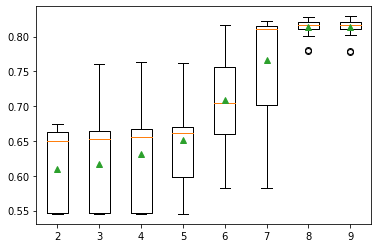

In [148]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot

## UNCOMMENT AND RUN if you have a lot of time. Will take a long time.

results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)    
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [149]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

def get_different_models():
    models = dict()
    # lr
    rfe = RFE(estimator=LogisticRegression(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['lr'] = Pipeline(steps=[('s',rfe),('m',model)])
    # lin
    rfe = RFE(estimator=LinearRegression(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['lin'] = Pipeline(steps=[('s',rfe),('m',model)])
    # cart
    rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['cart'] = Pipeline(steps=[('s',rfe),('m',model)])
    # rf
    rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['rf'] = Pipeline(steps=[('s',rfe),('m',model)])
    # gbm
    rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['gbm'] = Pipeline(steps=[('s',rfe),('m',model)])
    return models
diff_models = get_different_models()

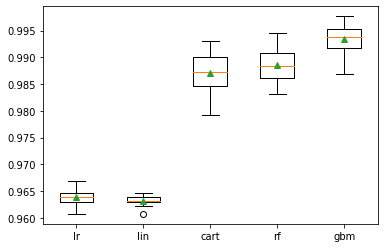

In [210]:
def evaluate_different_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# UNCOMMENT AND RUN if you have a lot of time. Will take a long time.

results, names = list(), list()
for name, model in diff_models.items():
    scores = evaluate_different_model(model, X, y)
    results.append(scores)
    names.append(name)

pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

### Feature Elimination and Variance Check: GBR

In [135]:
def fe_gbr(n_):
    from sklearn.ensemble import GradientBoostingRegressor

    # Select 10 features with RFE on a GradientBoostingRegressor, drop 3 features on each step
    rfe_gb = RFE(estimator=GradientBoostingRegressor(),
                n_features_to_select=n_, step=3)
    rfe_gb.fit(X_train, y_train)

    # Calculate the R squared on the test set
    r_squared = rfe_gb.score(X_test, y_test)
    print('The model can explain {0:.1%} of the variance in the test set'.format(r_squared))

    # Assign the support array to gb_mask
    gb_mask = rfe_gb.support_
    return gb_mask, r_squared

### Feature Elimination and Variance Check: RandomForest

In [136]:
def fe_rf(n_):
    from sklearn.ensemble import RandomForestRegressor

    rfe_rf = RFE(estimator=RandomForestRegressor(),
                n_features_to_select=n_, step=3)
    rfe_rf.fit(X_train, y_train)

    # Calculate the R squared on the test set
    r_squared = rfe_rf.score(X_test, y_test)
    print('The model can explain {0:.1%} of the variance in the test set'.format(r_squared))

    # Assign the support array to rf_mask
    rf_mask = rfe_rf.support_
    return rf_mask, r_squared

### Feature Elimination and Variance Check: Logistic

In [137]:
def fe_logistic(n_):
    from sklearn.linear_model import LogisticRegression
    rfe = RFE(estimator=LogisticRegression(), n_features_to_select=n_, step=3)
    rfe.fit(X_train, y_train)

    # Calculate the R squared on the test set
    r_squared = rfe.score(X_test, y_test)
    print('The model can explain {0:.1%} of the variance in the test set'.format(r_squared))

    # Assign the support array to rf_mask
    logi_mask = rfe.support_
    return logi_mask, r_squared

### Run All Feature Elimination code and compare

In [213]:
# RUN ALL MODELS

result = {}
for n in range(5, 130, 5):
    g, gr = fe_gbr(n)
    r, rr = fe_rf(n)
    lo, lor = fe_logistic(n)
    print(f'Number of Features: {n}')
    print(f'Gradient Boosing R-squared value: {gr}')
    print(f'Random Forest R-squared value: {rr}')
    print(f'Logistic Regression R-squared value: {lor}')
    result[n] = {'GB': gr, 'RF': rr, 'LR': lor}
    

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A colu

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A colu

The model can explain 47.8% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\l

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\l

The model can explain 70.1% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

The model can explain 96.0% of the variance in the test set
Number of Features: 5
Gradient Boosing R-squared value: 0.4778338599512414
Random Forest R-squared value: 0.7008602422676378
Logistic Regression R-squared value: 0.9602587800369686


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A colu

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A colu

The model can explain 49.1% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\l

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\l

The model can explain 87.6% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

The model can explain 95.9% of the variance in the test set
Number of Features: 10
Gradient Boosing R-squared value: 0.4909989796912332
Random Forest R-squared value: 0.8763735920595485
Logistic Regression R-squared value: 0.9593345656192237


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A colu

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A colu

The model can explain 51.4% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\l

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\l

The model can explain 82.9% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

The model can explain 96.1% of the variance in the test set
Number of Features: 15
Gradient Boosing R-squared value: 0.5135623769393491
Random Forest R-squared value: 0.8293943416075387
Logistic Regression R-squared value: 0.9605668515095502


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A colu

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A colu

The model can explain 52.2% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\l

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\l

The model can explain 81.8% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

The model can explain 97.0% of the variance in the test set
Number of Features: 20
Gradient Boosing R-squared value: 0.5215105981196646
Random Forest R-squared value: 0.8177057934358469
Logistic Regression R-squared value: 0.9704251386321626


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A colu

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A colu

The model can explain 52.3% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\l

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\l

The model can explain 83.2% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

The model can explain 97.0% of the variance in the test set
Number of Features: 25
Gradient Boosing R-squared value: 0.5230263213491587
Random Forest R-squared value: 0.8320147592721088
Logistic Regression R-squared value: 0.970117067159581


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A colu

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A colu

The model can explain 52.1% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\l

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\l

The model can explain 82.5% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

The model can explain 96.9% of the variance in the test set
Number of Features: 30
Gradient Boosing R-squared value: 0.5206807778182512
Random Forest R-squared value: 0.8247573486730682
Logistic Regression R-squared value: 0.9691928527418361


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A colu

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The model can explain 51.6% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\l

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\l

The model can explain 82.0% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

The model can explain 97.0% of the variance in the test set
Number of Features: 35
Gradient Boosing R-squared value: 0.5159643097610116
Random Forest R-squared value: 0.8197352851206064
Logistic Regression R-squared value: 0.9698089956869994


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A colu

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The model can explain 52.1% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\l

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\l

The model can explain 82.7% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

The model can explain 96.8% of the variance in the test set
Number of Features: 40
Gradient Boosing R-squared value: 0.5210650758633184
Random Forest R-squared value: 0.8272219620833987
Logistic Regression R-squared value: 0.9682686383240912


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A colu

The model can explain 51.8% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\l

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X[:, features], y, **fit_params)


The model can explain 82.2% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

The model can explain 97.0% of the variance in the test set
Number of Features: 45
Gradient Boosing R-squared value: 0.5182583851242177
Random Forest R-squared value: 0.8217906096350844
Logistic Regression R-squared value: 0.9698089956869994


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A colu

The model can explain 51.9% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\l

The model can explain 82.0% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

The model can explain 97.0% of the variance in the test set
Number of Features: 50
Gradient Boosing R-squared value: 0.5191844091436341
Random Forest R-squared value: 0.8202277234371154
Logistic Regression R-squared value: 0.9698089956869994


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A colu

The model can explain 51.7% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\l

The model can explain 82.5% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

The model can explain 97.0% of the variance in the test set
Number of Features: 55
Gradient Boosing R-squared value: 0.5165576801122728
Random Forest R-squared value: 0.8248380762659385
Logistic Regression R-squared value: 0.970117067159581


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A colu

The model can explain 51.8% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\l

The model can explain 82.2% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

The model can explain 96.6% of the variance in the test set
Number of Features: 60
Gradient Boosing R-squared value: 0.5176991269074773
Random Forest R-squared value: 0.8219343047503936
Logistic Regression R-squared value: 0.9661121380160197


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A colu

The model can explain 51.8% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\l

The model can explain 82.5% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

The model can explain 96.7% of the variance in the test set
Number of Features: 65
Gradient Boosing R-squared value: 0.5184944083625269
Random Forest R-squared value: 0.8248485708530117
Logistic Regression R-squared value: 0.9673444239063462


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A colu

The model can explain 51.8% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\l

The model can explain 82.6% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The model can explain 96.8% of the variance in the test set
Number of Features: 70
Gradient Boosing R-squared value: 0.5180533067503981
Random Forest R-squared value: 0.8264259880176974
Logistic Regression R-squared value: 0.9679605668515096


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A colu

The model can explain 51.8% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\l

The model can explain 82.3% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

The model can explain 97.1% of the variance in the test set
Number of Features: 75
Gradient Boosing R-squared value: 0.5180540404179768
Random Forest R-squared value: 0.8230862875006528
Logistic Regression R-squared value: 0.9707332101047443


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A colu

The model can explain 51.8% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\l

The model can explain 82.3% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

The model can explain 96.9% of the variance in the test set
Number of Features: 80
Gradient Boosing R-squared value: 0.5180539966761852
Random Forest R-squared value: 0.8234624780834285
Logistic Regression R-squared value: 0.9688847812692545


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A colu

The model can explain 51.8% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\l

The model can explain 83.0% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

The model can explain 96.9% of the variance in the test set
Number of Features: 85
Gradient Boosing R-squared value: 0.51837601645107
Random Forest R-squared value: 0.8303549999626952
Logistic Regression R-squared value: 0.9691928527418361


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A colu

The model can explain 51.8% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\l

The model can explain 82.3% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

The model can explain 96.9% of the variance in the test set
Number of Features: 90
Gradient Boosing R-squared value: 0.5183760164510699
Random Forest R-squared value: 0.8228659011721169
Logistic Regression R-squared value: 0.9688847812692545


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A colu

The model can explain 51.6% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\l

The model can explain 83.0% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

The model can explain 97.0% of the variance in the test set
Number of Features: 95
Gradient Boosing R-squared value: 0.5164799528188919
Random Forest R-squared value: 0.8295501458617782
Logistic Regression R-squared value: 0.9695009242144177


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A colu

The model can explain 51.8% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\l

The model can explain 82.2% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The model can explain 97.1% of the variance in the test set
Number of Features: 100
Gradient Boosing R-squared value: 0.5184517748652386
Random Forest R-squared value: 0.821574259686192
Logistic Regression R-squared value: 0.9707332101047443


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A colu

The model can explain 51.7% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\l

The model can explain 81.1% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

The model can explain 96.8% of the variance in the test set
Number of Features: 105
Gradient Boosing R-squared value: 0.5169822060247793
Random Forest R-squared value: 0.81126776790444
Logistic Regression R-squared value: 0.967652495378928


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A colu

The model can explain 51.8% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\l

The model can explain 83.3% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

The model can explain 96.9% of the variance in the test set
Number of Features: 110
Gradient Boosing R-squared value: 0.5184520184372009
Random Forest R-squared value: 0.832503161208974
Logistic Regression R-squared value: 0.9688847812692545


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A colu

The model can explain 51.8% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\l

The model can explain 81.8% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

The model can explain 96.2% of the variance in the test set
Number of Features: 115
Gradient Boosing R-squared value: 0.5176992339131226
Random Forest R-squared value: 0.8181715916467086
Logistic Regression R-squared value: 0.9624152803450401


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The model can explain 51.8% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\l

The model can explain 82.9% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

The model can explain 96.3% of the variance in the test set
Number of Features: 120
Gradient Boosing R-squared value: 0.5184510849394516
Random Forest R-squared value: 0.8285079526378226
Logistic Regression R-squared value: 0.9630314232902033


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The model can explain 51.8% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X[:, features], y, **fit_params)


The model can explain 82.2% of the variance in the test set


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

The model can explain 96.1% of the variance in the test set
Number of Features: 125
Gradient Boosing R-squared value: 0.517587045345187
Random Forest R-squared value: 0.8224493467929062
Logistic Regression R-squared value: 0.9614910659272952


C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [214]:
result

{5: {'GB': 0.4778338599512414,
  'RF': 0.7008602422676378,
  'LR': 0.9602587800369686},
 10: {'GB': 0.4909989796912332,
  'RF': 0.8763735920595485,
  'LR': 0.9593345656192237},
 15: {'GB': 0.5135623769393491,
  'RF': 0.8293943416075387,
  'LR': 0.9605668515095502},
 20: {'GB': 0.5215105981196646,
  'RF': 0.8177057934358469,
  'LR': 0.9704251386321626},
 25: {'GB': 0.5230263213491587,
  'RF': 0.8320147592721088,
  'LR': 0.970117067159581},
 30: {'GB': 0.5206807778182512,
  'RF': 0.8247573486730682,
  'LR': 0.9691928527418361},
 35: {'GB': 0.5159643097610116,
  'RF': 0.8197352851206064,
  'LR': 0.9698089956869994},
 40: {'GB': 0.5210650758633184,
  'RF': 0.8272219620833987,
  'LR': 0.9682686383240912},
 45: {'GB': 0.5182583851242177,
  'RF': 0.8217906096350844,
  'LR': 0.9698089956869994},
 50: {'GB': 0.5191844091436341,
  'RF': 0.8202277234371154,
  'LR': 0.9698089956869994},
 55: {'GB': 0.5165576801122728,
  'RF': 0.8248380762659385,
  'LR': 0.970117067159581},
 60: {'GB': 0.5176991269

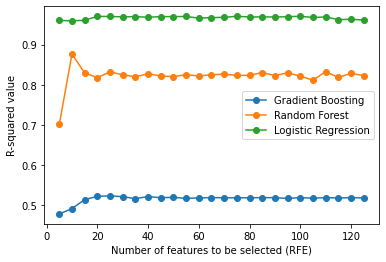

In [215]:
import matplotlib.pyplot as plt

gb = []
rf = []
lr = []
n = []
for k, v in result.items():
    gb.append(v['GB'])
    rf.append(v['RF'])
    lr.append(v['LR'])
    n.append(k)

plt.plot(n, gb, linestyle='-', marker='o', label='Gradient Boosting')
plt.plot(n, rf, linestyle='-', marker='o', label='Random Forest')
plt.plot(n, lr, linestyle='-', marker='o', label='Logistic Regression')

# x axis label
plt.xlabel('Number of features to be selected (RFE)')

# y axis label
plt.ylabel('R-squared value')

plt.legend()
plt.show()

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversio

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversio

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sjyhl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Optimal number of features : 70


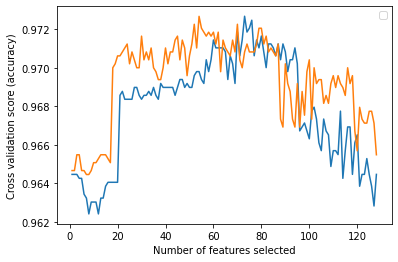

In [205]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring shows the proportion of correct classifications

min_features_to_select = 1  # Minimum number of features to consider

rfecv = RFECV(
    estimator=LogisticRegression(),
    step=1,
    cv=StratifiedKFold(2),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.legend()
plt.show()

In [206]:
selected_features = []
for i, rank in enumerate(rfecv.ranking_):
    feature = rfecv.feature_names_in_[i]
    selected_features.append({'feature': feature, 'rank': rank})
features_selected = [f['feature'] for f in selected_features if f['rank'] == 1]

In [207]:
df[(features_selected + ['patient_deceased'])].to_csv('chosen2.csv')

In [208]:
features_selected

['pa_race',
 'pa_maritalstatus',
 'epi_AdmitType',
 'DiagnosisCategory',
 'RoughAge',
 'M0140_ETHNIC_AI_AN',
 'M0140_ETHNIC_ASIAN',
 'M0140_ETHNIC_BLACK',
 'M0140_ETHNIC_HISP',
 'M0140_ETHNIC_NH_PI',
 'M1000_DC_IRF_14_DA',
 'M1000_DC_LTC_14_DA',
 'M1000_DC_LTCH_14_DA',
 'M1000_DC_OTH_14_DA',
 'M1000_DC_PSYCH_14_DA',
 'M1030_THH_ENT_NUTRITION',
 'M1030_THH_NONE_ABOVE',
 'M1030_THH_PAR_NUTRITION',
 'M1033_HOSP_RISK_MNTL_BHV_DCLN',
 'M1033_HOSP_RISK_NONE_ABOVE',
 'M1033_HOSP_RISK_WEIGHT_LOSS',
 'M1051_PVX_RCVD_AGNCY',
 'M1200_VISION',
 'M1306_UNHLD_STG2_PRSR_ULCR',
 'M1307_OLDST_STG2_AT_DSCHRG',
 'M1307_OLDST_STG2_ONST_DT',
 'M1311_NBR_PRSULC_STG2_A1',
 'M1311_NBR_ULC_SOCROC_STG2_A2',
 'M1311_NBR_ULC_SOCROC_STG3_B2',
 'M1311_NBR_ULC_SOCROC_STG4_C2',
 'M1311_NSTG_CVRG_SOCROC_E2',
 'M1311_NSTG_DEEP_TSUE_F1',
 'M1311_NSTG_DEEP_TSUE_SOCROC_F2',
 'M1311_NSTG_DRSG_D1',
 'M1311_NSTG_DRSG_SOCROC_D2',
 'M1330_STAS_ULCR_PRSNT',
 'M1332_NBR_STAS_ULCR',
 'M1334_STUS_PRBLM_STAS_ULCR',
 'M1340_SRGCL_WN

In [209]:
len(features_selected)

70